%matplotlib inline



Метод Affinity Propagation кластеризация

In [134]:
class AffinityPropagation:
    
    def dict(self, Iarray, Jarray, data_number):
        s=0
        for i in range(data_number):
            s += (Iarray[i]-Jarray[i])**2
        return -s
    
    def getResponsibility(self):
        
        lam = 0.5
        Y = np.repeat(-np.inf, self.S.shape[0])
        Y2 = np.repeat(-np.inf, self.S.shape[0])
        I = np.repeat(np.inf, self.S.shape[0])

        Rold = self.R.copy()
        S_A = self.S + self.A

        for i in range(S_A.shape[0]):
            for j in range(S_A.shape[1]):
                if Y[i] < S_A[i][j]:
                    Y2[i] = Y[i]
                    Y[i] = S_A[i][j]
                    I[i] = j
                elif Y2[i] < S_A[i][j]:
                    Y2[i] = S_A[i][j]

        self.R = self.S.copy()*100
        
        TempY = np.matlib.repmat(np.reshape(Y, (Y.shape[0], 1)),1, self.R.shape[0])*100
        
        for i in range(self.R.shape[0]):
            for j in range(self.R.shape[1]):
                self.R[i][j] = (int(self.R[i][j]) - int(TempY[i][j]))/100 

        for i in range(self.R.shape[0]):
            self.R[i][int(I[i])]= (int(self.S[i][int(I[i])]*100)-int(Y2[i]*100))/100
            
        for i in range(self.R.shape[0]):
            for j in range(self.R.shape[1]):
                self.R[i][j] = (int((1-lam)*100*self.R[i][j]) + int(lam*100*Rold[i][j]))/100   # экпоненциальное сглаживание
        
        return self.R
   

    def getAvailability(self):
        
        lam = 0.5
        Rp = self.R.copy()
        Aold = self.A.copy()
        i = 0
        
        for i in range(Rp.shape[0]):
            for j in range(Rp.shape[1]):
                if Rp[i][j] < 0:
                    Rp[i][j] = 0
        
        for i in range(Rp.shape[0]):
            Rp[i][i] = self.R[i][i]
            
        Atemp = np.repeat(0.0, Rp.shape[0])
        
        for i in range(Rp.shape[1]):
            for j in range(Rp.shape[0]):
                Atemp[i] += Rp[j][i]
            
        Atemp1 = np.matlib.repmat(Atemp,Rp.shape[0], 1)
        
        for i in range(self.A.shape[0]):
            for j in range(self.A.shape[1]):
                self.A[i][j] =  (int(Atemp1[i][j]*100) - int(Rp[i][j]*100))/100
           
        for i in range(self.A.shape[0]):
            Atemp[i] = self.A[i][i]
        
        for i in range(self.A.shape[0]):
            for j in range(self.A.shape[1]):
                if self.A[i][j] > 0:
                    self.A[i][j] = 0
        
        for i in range(self.A.shape[0]):
            self.A[i][i]=Atemp[i]
            
        for i in range(self.A.shape[0]):
            for j in range(self.A.shape[1]):
                self.A[i][j] = (int((1-lam)*100*self.A[i][j]) + int(lam*100*Aold[i][j]))/100 #  экпоненциальным сглаживанием.
    
        return self.A
    
    
    def getSimilarity(self, data_number, data_array, diagValue):
        
        for i in range(data_number):
            for j in range(i, data_number):
                if i==j:
                    self.S[i,j] = diagValue 
                else:
                    self.S[i,j] = self.dict(data_array[i:i+1][0], data_array[j:j+1][0], data_array.shape[1])
                    self.S[j,i] = self.S[i,j]
#         print(self.S)
         

    
    def getExemplars(self):
        
        E = self.A + self.R
        I = []
        Y = np.repeat(-np.inf, self.S.shape[0])
        U = np.repeat(np.inf, self.S.shape[0])
        
        for i in range(E.shape[0]):
            if E[i][i]>0:
                I.append(i)
        
        S1 = []
        for i in I:
            S1.append(np.reshape(self.S[:,int(i):int(i)+1], (1, self.S.shape[0]))[0])
        S1 = np.asarray(S1)
        
        for i in range(S1.shape[1]):
             for j in range(S1.shape[0]):
                if Y[i] < S1[j][i]:
                    Y[i] = S1[j][i]
                    U[i] = j
        
        j=0        
        for i in I:
            U[int(i)] = j
            j+=1
        
        ind =[]
        I = np.asarray(I)
        
        for i in range(U.shape[0]):
            if np.inf != U[i]:
                ind.append(I[int(U[i])])
        
        return ind
    
    
   # чем меньше diagValue, тем крупнее получаются группы.
    
    def main(self, data_number, data_array, iteration, diagValue):  
        
        self.S = np.zeros((data_number,data_number))
        self.getSimilarity(data_number, data_array, diagValue)
        
        self.S = self.S + 1*(10**(-12))* np.random.sample(self.S.shape[0]) * (self.S.max() - self.S.min())
        
        self.R = np.zeros((data_number,data_number))
        self.A = np.zeros((data_number,data_number))
    
        for i in range(iteration):
            self.R = self.getResponsibility()
            self.A = self.getAvailability()    
            
            print(i)
        
        return self.getExemplars()


Метод Fuzzy C-means кластеризация

матрица MemberShip!!!

In [135]:
class Cmeans:
    
    def inic(self, cluster, lenght):
        i = 0
        deff = lenght // cluster
        deftemp = 0
        n = lenght
        deftemp1 = deff
        
        while n > 0:
            for j in range(deftemp, deftemp1):
                self.MemberShip[i][j] = 1
            n -= deff
            if n - deff < deff:
                deff = n
            deftemp = deftemp1
            deftemp1 = deftemp1 + deff
            i+=1

    
    def getBeginCenter(self, W, cluster, attribute, lenght, data, p):
        poww = 2 / (W - 1)
        sum1 = 0
        sum2 = 0

        for i in range(cluster):
            for j in range(attribute):
                sum1 = 0
                sum2 = 0
                for k in range(lenght):
                        sum1 += pow(self.MemberShip[i][k], poww) * data[k][j]
                        sum2 += pow(self.MemberShip[i][k], poww)
                if sum2 != 0:
                    self.Centers[i][j] = sum1 / sum2
                else:
                    self.Centers[i][j] = sum1
    
    def setDistances(self, cluster, lenght, attribute, p, data):
        temp = 0
        minn = np.inf

        for j in range(lenght):
            minn = np.inf
            for k in range(cluster):
                for i in range(attribute):
                    temp += pow(abs(self.Centers[k][i] - data[j][i]), p)

                self.EuclideanDistanse[j][k] = pow(temp, 1.00 / p)

                if self.EuclideanDistanse[j][k] < minn:
                    minn = self.EuclideanDistanse[j][k];
                    self.dataCluster[j] = k
                temp = 0
    
    
    def setMemberShip(self,Sigma, W, cluster, lenght):
        NewMemberShip = np.zeros((cluster, lenght))
        poww = 2 / (W - 1);

        for j in range(cluster):
            temp = 0
            for i in range(lenght):
                for k in range(cluster):
                    if self.EuclideanDistanse[i][k] != 0:
                        temp += pow((self.EuclideanDistanse[i][j] / self.EuclideanDistanse[i][k]), poww)
                    else:
                        temp += 0

                if temp != 0:
                    NewMemberShip[j, i] = 1 / temp
                else:
                    NewMemberShip[j, i] = 1
                temp = 0

        maxx = 0

        for i in range(cluster):
            temp = 0
            for j in range(lenght):
                temp = abs(NewMemberShip[i][j] - self.MemberShip[i][j])
                if temp > maxx:
                    maxx = temp
                self.MemberShip[i][j] = NewMemberShip[i][j]
        return (Sigma < maxx)
    
    
    
    def resetCenters(self, W, cluster, attribute, lenght, data):
        sum1 = 0
        sum2 = 0
        poww = 2 / (W - 1)
        NewCenters = np.zeros((cluster, attribute))

        for i in range(cluster):
            for j in range(attribute):
                sum1 = 0
                sum2 = 0
                for k in range(lenght):
                    sum1 += pow(self.MemberShip[i][k], poww) * data[k][j]
                    sum2 += pow(self.MemberShip[i][k], poww)
                NewCenters[i][j] = sum1 / sum2

        changed = False
                                     
        for k in range(cluster):
            for j in range(attribute):
                if NewCenters[k][j] != self.Centers[k][j]:
                    changed = True
                self.Centers[k][j] = NewCenters[k][j]
        return changed;
    
    def run(self, cluster, attribute, lenght, data):
        Sigma = 0.01
        W = 2
        p = 2
                                     
        self.dataCluster = np.zeros(lenght)
        
        self.Centers = np.zeros((cluster, attribute))
        self.MemberShip = np.zeros((cluster, lenght))

        self.EuclideanDistanse = np.zeros((lenght, cluster))
        
        self.inic(cluster, lenght)
        self.getBeginCenter(W, cluster, attribute, lenght, data, p)
        self.setDistances(cluster, lenght, attribute, p,  data)
        i = 0
        while self.setMemberShip(Sigma, W, cluster, lenght):
            print(i)
            i+=1
            if not self.resetCenters(W, cluster, attribute, lenght, data):
                return self.Centers, self.dataCluster
            self.setDistances(cluster, lenght, attribute, p, data)
        return self.Centers, self.dataCluster
        


библиотеки

In [64]:
import random
import math
import pylab as pl
import numpy as np
from math import sqrt
import numpy.matlib
import plotly.graph_objects as go
import pandas as pd
import csv
from sklearn import preprocessing
import matplotlib.pyplot as plt

Каталоги сейсмических данных

"geoData.csv" - The International Seismological Centre (ISC) (http://www.isc.ac.uk/)

"geoDatasmall.csv" - The USGS Earthquake Hazards Program  (https://earthquake.usgs.gov/)


Bottom -41
Top - 45
Left - 37
Right - 49





!цвет, чтение данных

In [51]:
DataFile1 = "geoData.csv"
DataFile2 = "geoDatasmall.csv"

colors = ['aqua','blanchedalmond','lime','blue','blueviolet','chartreuse','crimson','cyan','darkblue','darkcyan',
          'darkgoldenrod','darkslategray' ,'darkgreen','darkmagenta','darkorange','darkorchid','darkred','darkturquoise','darkviolet',
          'deeppink','deepskyblue','dodgerblue','goldenrod','greenyellow','firebrick','forestgreen','fuchsia','gold',
          'hotpink','indianred','green','indigo','lawngreen','magenta','maroon','mediumblue','mediumorchid','midnightblue',
          'mediumaquamarine','mediumturquoise','mediumvioletred','moccasin','pink','steelblue','olive','orange','orchid',
          'palevioletred','red','yellowgreen','navy','plum','sandybrown','thistle','tomato','yellow','skyblue','orangered',
          'olivedrab','coral','antiquewhite','darkolivegreen','violet','khaki','brown','burlywood','aquamarine','slateblue',
           'lemonchiffon','lightblue', 'lightcoral','lightcyan','lightgoldenrodyellow','lightgray','lightgrey','lightgreen',
           'lightpink','lightsalmon','lightseagreen','lightskyblue','lightslategray','lightslategrey','lightsteelblue','lightyellow',
         'aqua','blanchedalmond','lime','blue','blueviolet','chartreuse','crimson','cyan','darkblue','darkcyan',
          'darkgoldenrod','darkslategray' ,'darkgreen','darkmagenta','darkorange','darkorchid','darkred','darkturquoise','darkviolet',
          'deeppink','deepskyblue','dodgerblue','goldenrod','greenyellow','firebrick','forestgreen','fuchsia','gold',
          'hotpink','indianred','green','indigo','lawngreen','magenta','maroon','mediumblue','mediumorchid','midnightblue',
          'mediumaquamarine','mediumturquoise','mediumvioletred','moccasin','pink','steelblue','olive','orange','orchid',
          'palevioletred','red','yellowgreen','navy','plum','sandybrown','thistle','tomato','yellow','skyblue','orangered',
          'olivedrab','coral','antiquewhite','darkolivegreen','violet','khaki','brown','burlywood','aquamarine','slateblue',
           'lemonchiffon','lightblue', 'lightcoral','lightcyan','lightgoldenrodyellow','lightgray','lightgrey','lightgreen',
           'lightpink','lightsalmon','lightseagreen','lightskyblue','lightslategray','lightslategrey','lightsteelblue','lightyellow']

Data = pd.read_csv(DataFile2, header = None, names = ['latitude','longitude','depth','mag','place','year','month','day','hour','minute','second'], delimiter='\t')
Data=Data.iloc[1:]
Data
# Data = pd.read_csv(DataFile1, header = None, names = ['longitude','latitude','depth','mag','years','month','day','hour','minute','second','author'], delimiter='\t')
# Data=Data.iloc[1:]
# Data

,latitude,longitude,depth,mag,place,year,month,day,hour,minute,second
0.0,44.1686,39.0414,10.0,4.5,"2 km N of Agoy, Russia",2020,9,1,0,59,5
1.0,41.8382,43.7917,10.0,4.3,"22 km S of Agara, Georgia",2020,7,12,5,54,55
2.0,44.8766,37.1141,37.85,4.3,"16km W of Anapa, Russia",2020,3,15,5,36,0
3.0,43.4,46.053999999999995,10.0,4.3,"6km NW of Gudermes, Russia",2020,2,6,15,25,17
4.0,42.9381,44.3096,10.0,4.2,"11km N of Verkhniy Fiagdon, Russia",2020,1,26,21,1,40
...,...,...,...,...,...,...,...,...,...,...,...
675.0,41.277,43.898,10.0,5.2,Georgia (Sak'art'velo),1958,5,30,5,16,15
676.0,43.071000000000005,47.793,15.0,5.6,"Caucasus region, Russia",1958,5,6,4,15,48
677.0,42.52,42.352,10.0,5.6,Georgia (Sak'art'velo),1957,1,26,16,30,50
678.0,41.13,48.129,15.0,5.4,Azerbaijan,1953,4,30,15,45,26


%matplotlib inline
обработка данных

In [80]:
SeisData = Data.copy()

SeisData['longitude']=pd.to_numeric(SeisData['longitude'])
SeisData['latitude']=pd.to_numeric(SeisData['latitude'])
SeisData['depth']=pd.to_numeric(SeisData['depth'])
SeisData['mag']=pd.to_numeric(SeisData['mag'])
# удаление данных с магнитудой меньше 4
for i in range(SeisData.shape[0]):
    if SeisData['mag'][i] < 4:
        SeisData.drop([i], inplace = True)

# удаление столбцов не участвующих в анализе

SeisData.drop(['mag','place','year','month','day','hour','minute', 'second'],axis='columns', inplace=True) # DataFile1
# SeisData.drop(['mag','author','year','month','day','hour','minute', 'second'],axis='columns', inplace=True) # DataFile2
SeisData = np.asarray(SeisData)
print(SeisData)

# нормализация 1

# X_mean =np.repeat(0, SeisData.shape[1])
# X_std = np.repeat(0, SeisData.shape[1])
# for i in range(SeisData.shape[1]):
#     X_mean[i] = SeisData[:, i:i+1].mean()
    
#     X_std[i] = SeisData[:, i:i+1].std()
#     if X_std[i] == 0:
#         X_std[i] = 1   
# X_mean =np.reshape(X_mean, (X_mean.shape[0], 1))
# X_std =np.reshape(X_std, (X_std.shape[0], 1))
# SeisData = (np.reshape(SeisData, (SeisData.shape[1], SeisData.shape[0])) - X_mean) / X_std
# SeisData = np.reshape(SeisData, (SeisData.shape[1], SeisData.shape[0]))

# нормализация 2
# SeisDataNorn = preprocessing.normalize(SeisData)
# print(SeisDataNorn)


[[44.1686 39.0414 10.    ]
 [41.8382 43.7917 10.    ]
 [44.8766 37.1141 37.85  ]
 ...
 [42.52   42.352  10.    ]
 [41.13   48.129  15.    ]
 [42.143  45.345  15.    ]]


Результаты Affinity Propagation кластеризации

In [81]:
AP = AffinityPropagation()
centers = AP.main(SeisData.shape[0], SeisData, 50, -20)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [82]:
centerUnique = []
colorArray = []

for c in centers:
    if c not in centerUnique:
        centerUnique.append(c)
    
for c in centers:    
    colorArray.append(colors[centerUnique.index(int(c))]) # Цвет!!!
    
    
SeisData1 = pd.DataFrame(SeisData)

In [84]:
fig = go.Figure(
    data=[
        
            go.Scatter3d(
            x=SeisData1[0],
            y=SeisData1[1],
            z=-SeisData1[2],
            mode='markers',
            marker=dict(
            size=10,
            color=colorArray,   
            opacity=0.8
    ))])

# tight layout
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.show()

40


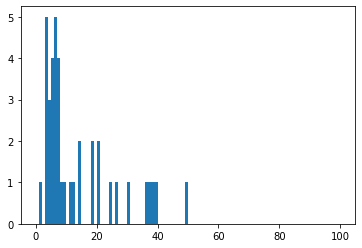

In [83]:
clusters = dict()

for exemplar in centers:
    if exemplar not in clusters:
        clusters[exemplar] = 1
    else:
        clusters[exemplar] += 1
    
print(len(centerUnique)) #количество кластеров        
plt.hist(clusters.values(), bins=100, range=(0, 100))
plt.show() # размеры кластеров

результаты Fuzzy C-means кластеризация

вести посчет времени

In [106]:
FCM = Cmeans()
NumberClust = 75
cent, dataCl = FCM.run(NumberClust, SeisData.shape[1], SeisData.shape[0], SeisData)

cent

[[1. 1. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 1. 1.]]
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28


array([[ 42.48635653,  40.88858533,  13.86110182],
       [ 43.25131651,  41.13040091,   9.95746566],
       [ 43.36144918,  44.98337344,  23.59018868],
       [ 43.36097149,  45.53882675,  18.20583173],
       [ 41.73578518,  46.62754741,  10.00687311],
       [ 42.59461234,  45.22692171,  17.45459647],
       [ 42.94733378,  46.40832129,  76.18609539],
       [ 43.0048089 ,  45.43371403,  53.05764495],
       [ 42.54609205,  47.83519574,  22.1363663 ],
       [ 41.51270908,  46.75015568,  16.81404954],
       [ 44.88396622,  37.54260037,  33.00155159],
       [ 42.40981376,  44.10548832,  20.4300148 ],
       [ 42.61377289,  45.09054921,  33.00269285],
       [ 42.25426546,  47.94824273,  10.03716643],
       [ 42.56594263,  43.61556947,  14.29247052],
       [ 41.78600485,  47.70182815,  65.54172781],
       [ 43.20579559,  46.11541321,  13.10295366],
       [ 42.63614697,  43.44600135,  12.09313682],
       [ 42.24606738,  47.20832492,  25.03547856],
       [ 42.9790701 ,  46.53634

In [107]:
centers = []
colorArray = []

for c in range(NumberClust):
        centers.append(c)
        
for c in range(dataCl.shape[0]):   
    colorArray.append(colors[centers.index(dataCl[c])])

SeisData1 = pd.DataFrame(SeisData)

In [128]:
fig = go.Figure(
    data=[
        
            go.Scatter3d(
            x=SeisData1[0],
            y=SeisData1[1],
            z=-SeisData1[2],
            mode='markers',
            marker=dict(
            size=5,
            color=colorArray,   
            opacity=0.8
    )
      ), go.Scatter3d(
                x=pd.DataFrame(cent[:, 0:1])[0],
                y=pd.DataFrame(cent[:, 1:2])[0],
                z=-pd.DataFrame(cent[:, 2:3])[0],
                mode='markers', 
                marker=dict( size=10, color=colors[:NumberClust], opacity=0.8 )
)
    
])

# tight layout
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.show()

75


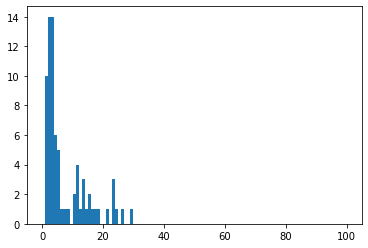

In [125]:
clusters = dict()

for exemplar in range(dataCl.shape[0]):
    if dataCl[exemplar] not in clusters:
        clusters[dataCl[exemplar]] = 1
    else:
        clusters[dataCl[exemplar]] += 1
    
print(NumberClust) #количество кластеров        
plt.hist(clusters.values(), bins=100, range=(0, 100))
plt.show() # размеры кластеров

In [133]:
max(clusters.values()) // больше всего событий

29